# **Image Retrieval Using DCH**

Accurate image retrieval is a core technology for shopping by picture taking, and also becomes a hotspot in the academia and industry. Here, we take a digital device image dataset in a real snap-to-shop scenario, provided in Huawei DIGIX Global AI Challenge. In a Content Based Image Retrieval (CBIR) System, the task is to retrieve similar images from a large database given a query image. The usual procedure is to extract some useful features from the query image, and retrieve images which have similar set of features. For this purpose, a suitable similarity measure is chosen, and images with high similarity scores are retrieved. Naturally the choice of these features play a very important role in the success of this system, and high level features are required to reduce the semantic gap.

Deep Hashing methods are most commonly used to implement content based image retrieval. If you do not know about image retrieval Check out this [paper](https://arxiv.org/pdf/2006.05627.pdf).

Out of all the Deep Hashing methods we shall implement the DEEP CAUCHY HASHING for content based image retrieval. Here is the [paper](http://ise.thss.tsinghua.edu.cn/~mlong/doc/deep-cauchy-hashing-cvpr18.pdf).

If you find the notebook insightful please do upvote it.

## Setup

Add train data to your notebook using this dataset https://www.kaggle.com/varenyambakshi/digixai-image-retrieval.

Add test data to your notebook using this dataset https://www.kaggle.com/varenyambakshi/digixalgoai.

Lets start by importing necessary packages. Also make sure that you have added Google Cloud Services to your notebook (if not go to the "Add-ons" section and attach it to your notebook) and are using GPU.

In [1]:
import torchvision
import torchvision.datasets as dset
from torchvision import transforms, models
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image,ImageOps
import torch
from torch.autograd import Variable  
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import pandas as pd
from skimage import io
import os
import IPython
import numbers
%matplotlib inline

In [2]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [3]:
class Config():  
    image_dir = "../input/digixai-image-retrieval/train_data/"
    labels_dir = "../input/digixai-image-retrieval/train_data/label.txt"
    gallery_dir = "../input/digixalgoai/test_data_B/gallery/"
    query_dir = "../input/digixalgoai/test_data_B/query/"
    outfile = "/content/drive/My Drive/log.txt"
    feature_file = "./features.pth"
    model = "./model.pth"
    loss = {"gamma":5,"q_lambda":1,"normed":True}
    
    feature_batch_size = 64            #batch size used while extracting features
    train_batch_size = 128             #batch size used while training the network with extracted features
    train_number_epochs = 30          #batch size used while extracting features
    test_batch_size = 64
    #some tranformations to be applied on the images
    transformer = transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor()])

## Helper functions

Here we define two helper functions. `imshow` is for displaying images while `show_plot` is for plotting the loss function.

In [4]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.figure(figsize=(21,12))
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.figure(figsize=(14,8))
    plt.plot(iteration,loss)
    plt.show()

## Preprocesss

Preprocessing is an important step which can greatly influence the performance of the model. Various preprocessing techniques like cropping, rotating, flipping and other data augmentation techniques come under this. 

Some preprocessing techniques are applied before training, while some are used at time of testing like test10crop.

In [5]:
class ResizeImage():
    def __init__(self, size):
      if isinstance(size, int):
        self.size = (int(size), int(size))
      else:
        self.size = size
    def __call__(self, img):
      th, tw = self.size
      return img.resize((th, tw))


class PlaceCrop(object):
    """Crops the given PIL.Image at the particular index.
    Args:
        size (sequence or int): Desired output size of the crop. If size is an
            int instead of sequence like (w, h), a square crop (size, size) is
            made.
    """

    def __init__(self, size, start_x, start_y):
        if isinstance(size, int):
            self.size = (int(size), int(size))
        else:
            self.size = size
        self.start_x = start_x
        self.start_y = start_y

    def __call__(self, img):
        """
        Args:
            img (PIL.Image): Image to be cropped.
        Returns:
            PIL.Image: Cropped image.
        """
        th, tw = self.size
        return img.crop((self.start_x, self.start_y, self.start_x + tw, self.start_y + th))


class ForceFlip(object):
    """Horizontally flip the given PIL.Image randomly with a probability of 0.5."""

    def __call__(self, img):
        """
        Args:
            img (PIL.Image): Image to be flipped.
        Returns:
            PIL.Image: Randomly flipped image.
        """
        return img.transpose(Image.FLIP_LEFT_RIGHT)

def image_train(resize_size=256, crop_size=224):
    
  normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                   std=[0.229, 0.224, 0.225])
  return  transforms.Compose([
        transforms.Resize(resize_size),
        transforms.CenterCrop(crop_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize
    ])

def image_test(resize_size=256, crop_size=224):
  normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                   std=[0.229, 0.224, 0.225])
  #ten crops for image when validation, input the data_transforms dictionary
  start_first = 0
  start_center = (resize_size - crop_size - 1) / 2
  start_last = resize_size - crop_size - 1
 
  return transforms.Compose([
    ResizeImage(resize_size),
    PlaceCrop(crop_size, start_center, start_center),
    transforms.ToTensor(),
    normalize
  ])

def image_test_10crop(resize_size=256, crop_size=224):
  normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                   std=[0.229, 0.224, 0.225])
  #ten crops for image when validation, input the data_transforms dictionary
  start_first = 0
  start_center = (resize_size - crop_size - 1) / 2
  start_last = resize_size - crop_size - 1
  data_transforms = {}
  data_transforms['val0'] = transforms.Compose([
      ResizeImage(resize_size),ForceFlip(),
      PlaceCrop(crop_size, start_first, start_first),
      transforms.ToTensor(),
      normalize
  ])
  data_transforms['val1'] = transforms.Compose([
      ResizeImage(resize_size),ForceFlip(),
      PlaceCrop(crop_size, start_last, start_last),
      transforms.ToTensor(),
      normalize
  ])
  data_transforms['val2'] = transforms.Compose([
      ResizeImage(resize_size),ForceFlip(),
      PlaceCrop(crop_size, start_last, start_first),
      transforms.ToTensor(),
      normalize
  ])
  data_transforms['val3'] = transforms.Compose([
      ResizeImage(resize_size),ForceFlip(),
      PlaceCrop(crop_size, start_first, start_last),
      transforms.ToTensor(),
      normalize
  ])
  data_transforms['val4'] = transforms.Compose([
      ResizeImage(resize_size),ForceFlip(),
      PlaceCrop(crop_size, start_center, start_center),
      transforms.ToTensor(),
      normalize
  ])
  data_transforms['val5'] = transforms.Compose([
      ResizeImage(resize_size),
      PlaceCrop(crop_size, start_first, start_first),
      transforms.ToTensor(),
      normalize
  ])
  data_transforms['val6'] = transforms.Compose([
    ResizeImage(resize_size),
    PlaceCrop(crop_size, start_last, start_last),
    transforms.ToTensor(),
    normalize
  ])
  data_transforms['val7'] = transforms.Compose([
    ResizeImage(resize_size),
    PlaceCrop(crop_size, start_last, start_first),
    transforms.ToTensor(),
    normalize
  ])
  data_transforms['val8'] = transforms.Compose([
    ResizeImage(resize_size),
    PlaceCrop(crop_size, start_first, start_last),
    transforms.ToTensor(),
    normalize
  ])
  data_transforms['val9'] = transforms.Compose([
    ResizeImage(resize_size),
    PlaceCrop(crop_size, start_center, start_center),
    transforms.ToTensor(),
    normalize
  ])
  return data_transforms

## Loss

Here we define the loss function of DCH. We basically pass two batches of images encoded in hashbits where some images are semantically (content-wise) similar while others are different. The more the distance between hashbits of similar images, the more heavily loss function punishes and vice-versa. To know about the maths you can refer the [paper](http://ise.thss.tsinghua.edu.cn/~mlong/doc/deep-cauchy-hashing-cvpr18.pdf).  

We also write mention the equation number in the code in case you are following the paper.

In [6]:

def d(u, v, hashbit):
    
    inner_product = torch.mm(u, v.t())
    norm = torch.mm(u.pow(2).sum(dim=1, keepdim=True).pow(0.5), v.pow(2).sum(dim=1, keepdim=True).pow(0.5).t())
    cos = inner_product / norm.clamp(min=0.00001)
    
    #formula 6
    return (1 - cos.clamp(max=0.99999)) * hashbit / 2
    
def pairwise_loss(u, v, label1, label2, hashbit = 48,gamma=1.0, q_lambda=1.0,normed=True):

    label_ip = Variable(label1 == (label2.transpose(0,1))).float()
    s = torch.clamp(label_ip, 0.0, 1.0)

    one = torch.ones((u.size(0), hashbit)).cuda()

    if (1 - s).sum() != 0 and s.sum() != 0:
        # formula 2
        positive_w = s * s.numel() / s.sum()
        negative_w = (1 - s) * s.numel() / (1 - s).sum()
        w = positive_w + negative_w

    else:
        # if either |S1|==0 or |S2|==0
        w = 1

    d_hi_hj = d(u, v, hashbit)

    # formula 8
    cauchy_loss = w * (s * torch.log(d_hi_hj / gamma) + torch.log(1 + gamma / d_hi_hj))

    # formula 9
    quantization_loss = torch.log(1 + d(u.abs(), one, hashbit) / gamma) + torch.log(1 + d(v.abs(), one, hashbit) / gamma)

    # formula 7
    loss = cauchy_loss.mean() + q_lambda * quantization_loss.mean()

    return loss

## Network

Although there are many models available, we shall be using RESNET50. We will have broadly three types of layers namely 
1. Convolution layers
1. Fully connected layers 
1. Hashing layer

Instead of training the whole network at once we can use transfered learing and train few of the last layers. To further speed up training we can extract the intermediate feaures so that we do not have to pass the images everytime through the whole network. Instead we can just train on the extracted features.

In [7]:
resnet_dict = {"ResNet18":models.resnet18, "ResNet34":models.resnet34, "ResNet50":models.resnet50, "ResNet101":models.resnet101, "ResNet152":models.resnet152} 
class ResNetFc(nn.Module):
  def __init__(self, name, hash_bit):
    super(ResNetFc, self).__init__()
    model_resnet = resnet_dict[name](pretrained=True)
    self.conv1 = model_resnet.conv1
    self.bn1 = model_resnet.bn1
    self.relu = model_resnet.relu
    self.maxpool = model_resnet.maxpool
    self.layer1 = model_resnet.layer1
    self.layer2 = model_resnet.layer2
    self.layer3 = model_resnet.layer3
    self.layer4 = model_resnet.layer4
    self.avgpool = model_resnet.avgpool
    
    #convolution layers
    self.feature_layers = nn.Sequential(self.conv1, self.bn1, self.relu, self.maxpool, \
                         self.layer1, self.layer2, self.layer3, self.layer4, self.avgpool)
    
    #fully connected layers
    self.fc = nn.Sequential(nn.Linear(model_resnet.fc.in_features,256),
                            nn.ReLU(),)
    
    #hashing layer outputs the hashbits
    self.hash_layer = nn.Linear(256, hash_bit)
    #initializing the layers
    self.hash_layer.weight.data.normal_(0, 0.01)
    self.hash_layer.bias.data.fill_(0.0)
    
    self.iter_num = 0
    self.__in_features = hash_bit
    self.step_size = 300
    self.gamma = 0.005
    self.power = 0.5
    self.init_scale = 1.0
    self.activation = nn.Tanh()
    self.scale = self.init_scale

    #passing through the whole network at once
  def forward(self, x):
    if self.training:
        self.iter_num += 1

    x = self.feature_layers(x)
    x = x.view(x.size(0), -1)
    x = self.fc(x)
    y = self.hash_layer(x)
    y = self.activation(y)
    return y
    
    #passing only through the convolution layers to extract intermediate features
  def forward_static(self,x):
    x = self.feature_layers(x)
    return x
    
    #passing the extracted features through the rest of the network for training
  def forward_train(self,x):
    x = x.view(x.size(0),-1)
    x = self.fc(x)
    y = self.hash_layer(x)
    y = self.activation(y)
    return y

  def output_num(self):
    return self.__in_features



## Extracting Intermediate Features

The dataset class defined for the purpose of extracting features as mentioned earlier.

In [8]:
class Encodings(Dataset):

    def __init__(self, image_dir, path, transform=None):

        imgs = pd.read_csv(path, header=None).iloc[:,0]
        self.labels = pd.read_csv(path, header=None).iloc[:,1]
        self.img_path = image_dir+imgs
        #self.data =  pd.DataFrame(img_list)
        # self.image_dir = image_dir
        self.transform = transform
        

    def __len__(self):
        return len(self.img_path)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.img_path.iloc[idx]
        label = self.labels.iloc[idx]
        image = Image.open(img_name).convert("RGB")      

        if self.transform:
          image = self.transform(image)

        sample = {'image':image, 'label':self.labels.iloc[idx]}

        return sample

In [9]:
#returens
#encodings -- extracted intermediate features
#labels-- the class to which the image belongs
#indexes-- indices of the image in the data

def feature_extractor(encoding_dataloader, verbosity):

    base_network.eval()

    with torch.no_grad(): 

        for i_batch, sample in enumerate(encoding_dataloader):
            
            length = len(sample['label'])

            if torch.cuda.is_available():
                sample['image'] = sample['image'].cuda()
                sample['label'] = sample['label'].cuda()

            encoding = base_network.forward_static(sample['image'])
            index = torch.Tensor(np.arange(i_batch*length,(i_batch+1)*length))

            if not i_batch: 
                encodings = encoding
                labels = sample['label']
                indexes = index
                continue

            encodings = torch.cat([encodings, encoding], dim=0)
            labels = torch.cat([labels,sample['label']],dim=0)
            indexes = torch.cat([indexes,index],dim=0)

            if verbosity: 
                for img in sample['label']:
                    print("Image from label {} succesfully extracted".format(img))

        return encodings, labels, indexes

In [10]:
hash_bit = 32 #Number of bits onto which each image is mapped
base_network = ResNetFc(name="ResNet50",hash_bit=hash_bit).cuda()

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [11]:
image_dataset = Encodings(image_dir = Config.image_dir, path = Config.labels_dir, transform = Config.transformer)
encoding_dataloader = DataLoader(image_dataset, shuffle=False, num_workers=0, batch_size=Config.train_batch_size)

In [12]:
encodings, labels, indexes = feature_extractor(encoding_dataloader, verbosity=0)

In [13]:
encodings_dict = {"encodings":encodings, "labels":labels, "indexes":indexes}
torch.save(encodings_dict, Config.feature_file)

## Creating Dataset

We shall now create a function to perform train test split on the data. First load the extracted intermediate features.


In [14]:
encodings_dict = torch.load(Config.feature_file)

In [15]:
class NetworkDataset(Dataset):
    
    def __init__(self,encodings_dict):
        self.encodings_dict = encodings_dict    
        # self.transform = transform
        # self.should_invert = should_invert
        
    def __getitem__(self,index):

        idx1 = int(random.choice(self.encodings_dict['indexes']))
        label1 = self.encodings_dict['labels'][idx1]

        # idx2 = int(random.choice(self.encodings_dict['indexes']))
        # label2 = self.encodings_dict['labels'][idx2]


        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1) 

        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                idx2 = idx1 + random.randint(-10,10)                                 # as semantically similar images belong to 
                while (idx2>=len(self.encodings_dict["indexes"]) or idx2<0):         # the same class and are stored together
                    idx2 = idx1+random.randint(-10,10)                               # we just search in the nearby background of 
                                                                                     # the image 1.
                label2 = self.encodings_dict['labels'][idx2] 
                if label1 == label2:
                    break
        else:
            while True:
                #keep looping till a different class image is found        
                idx2 = int(random.choice(self.encodings_dict['indexes']))
                label2 = self.encodings_dict['labels'][idx2] 
                if label1 != label2:
                    break


        img1 = self.encodings_dict['encodings'][idx1]
        img2 = self.encodings_dict['encodings'][idx2]
        
        return img1, img2 , label1, label2
    
    def __len__(self):
        return len(self.encodings_dict["indexes"])

In [16]:
def load_split_train_test(encodings_dict, valid_size = .1,batch_size=64):

    train_data = NetworkDataset(encodings_dict = encodings_dict)

    num_train = len(encodings_dict['indexes'])
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)

    from torch.utils.data.sampler import SubsetRandomSampler

    train_idx, test_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)
    
    trainloader = torch.utils.data.DataLoader(train_data,
                sampler=train_sampler, batch_size=batch_size)
    testloader = torch.utils.data.DataLoader(train_data,
                sampler=test_sampler, batch_size=batch_size)
    

    return trainloader, testloader

In [17]:
train_dataloader, valid_dataloader = load_split_train_test(encodings_dict, 0.05) # 5% data is for validation

## Train from Extracted 

In [18]:
print(base_network)

ResNetFc(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1

In [19]:
optimizer = optim.AdamW([{"params":base_network.fc.parameters(), "lr":0.00001},{"params":base_network.hash_layer.parameters(), "lr":0.0001}])

In [20]:
counter = []
loss_history = [] 
iteration_number= 0

In [21]:
base_network.train()

for epoch in range(1,Config.train_number_epochs+1):

    for i, data in enumerate(train_dataloader,1):

        inputs1, inputs2 , label1, label2 = data
        # inputs1, inputs2 , label1, label2 = inputs1.cuda(), inputs2.cuda() , label1.cuda(), label2.cuda()

        label1.unsqueeze_(1)
        label2.unsqueeze_(1)

        inputs = torch.cat((inputs1, inputs2), dim=0)

        optimizer.zero_grad()
        outputs = base_network.forward_train(inputs)
        similarity_loss = pairwise_loss(outputs.narrow(0,0,inputs1.size(0)),outputs.narrow(0,inputs1.size(0),inputs2.size(0)),label1,label2,hashbit = hash_bit,gamma=Config.loss["gamma"],normed=Config.loss["normed"],q_lambda=Config.loss["q_lambda"])
        similarity_loss.backward()
        optimizer.step()


        if i %10 == 0 :
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(similarity_loss.item()) 

    print("Epoch number {}\n Current loss {}\n".format(epoch,similarity_loss.item()))

Epoch number 1
 Current loss 1.2545180320739746

Epoch number 2
 Current loss 1.1674963235855103

Epoch number 3
 Current loss 0.9985135793685913

Epoch number 4
 Current loss 1.0777499675750732

Epoch number 5
 Current loss 1.1257171630859375

Epoch number 6
 Current loss 1.0668336153030396

Epoch number 7
 Current loss 1.0896775722503662

Epoch number 8
 Current loss 1.0614994764328003

Epoch number 9
 Current loss 1.0894829034805298

Epoch number 10
 Current loss 1.0440446138381958

Epoch number 11
 Current loss 1.0591930150985718

Epoch number 12
 Current loss 1.0213385820388794

Epoch number 13
 Current loss 0.9359531998634338

Epoch number 14
 Current loss 0.9469719529151917

Epoch number 15
 Current loss 1.0183074474334717

Epoch number 16
 Current loss 0.9510996341705322

Epoch number 17
 Current loss 0.9839282631874084

Epoch number 18
 Current loss 0.9218747019767761

Epoch number 19
 Current loss 0.9816086292266846

Epoch number 20
 Current loss 0.9940961599349976

Epoch num

In [22]:
torch.save(base_network.state_dict(),Config.model)

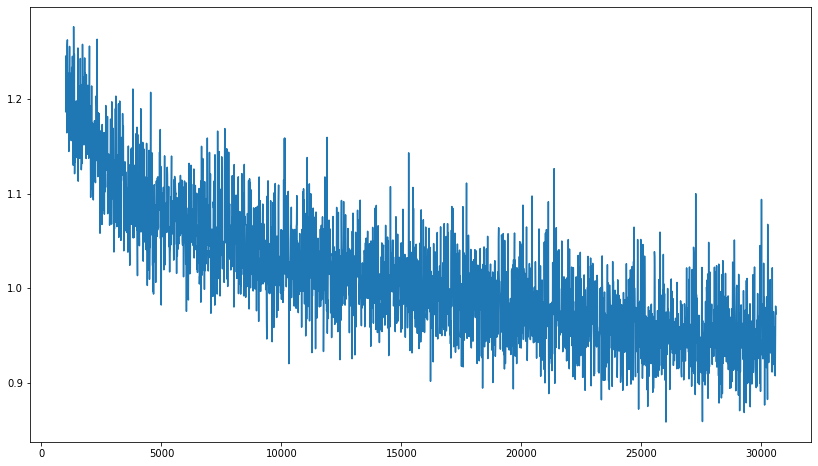

In [23]:
show_plot(counter[100:],loss_history[100:])

## Validation

Checking validation dataset loss value.

In [24]:
base_network.eval()

valid_loss = 0 

with torch.no_grad():

    for data in valid_dataloader:

        inputs1, inputs2 , label1, label2 = data
        # inputs1, inputs2 , label1, label2 = inputs1.cuda(), inputs2.cuda() , label1.cuda(), label2.cuda()

        label1.unsqueeze_(1)
        label2.unsqueeze_(1)

        inputs = torch.cat((inputs1, inputs2), dim=0)
                           
        outputs = base_network.forward_train(inputs)
        similarity_loss = pairwise_loss(outputs.narrow(0,0,inputs1.size(0)),outputs.narrow(0,inputs1.size(0),inputs2.size(0)),label1,label2,hashbit = hash_bit,gamma=Config.loss["gamma"],normed=Config.loss["normed"],q_lambda=Config.loss["q_lambda"])

        valid_loss = valid_loss + similarity_loss.item()

    print("loss = {}".format(valid_loss/len(valid_dataloader)))

loss = 0.9488807629655909


## Testing

Lets run our code on the test dataset. The test dataset comprises of 

1. Gallery images
2. Query images

For every query image we have to find the gallery images which are similar to the query images. So first we shall pass both the query as well as gallery images through the network and then comparing the hash bits find the similar images.

In [25]:
hash_bit = 32
base_network = ResNetFc(name="ResNet50",hash_bit=hash_bit).cuda()
base_network.load_state_dict(torch.load(Config.model))

<All keys matched successfully>

In [26]:
class Encodings(Dataset):

    def __init__(self, image_dir, transform=None):
        
        img_list = os.listdir(image_dir)
        self.data =  pd.DataFrame(img_list)
        self.image_dir = image_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.image_dir,
                                self.data.iloc[idx, 0])
        
        image = Image.open(img_name).convert("RGB")

        if self.transform:
          image = self.transform(image)

        sample = {'image':image, 'name':self.data.iloc[idx,0]}

        return sample

In [27]:
#passes the batch of images through the network and returns the output

def encoding_extractor(encoding_dataloader, verbosity):

    base_network.eval()

    with torch.no_grad(): 

        for i_batch, sample in enumerate(encoding_dataloader):

            sample['image'] = sample['image'].cuda()

            encoding = base_network.forward(sample['image'])
            
            if not i_batch: 
                encodings = encoding
                names = sample['name']
                continue

            encodings = torch.cat([encodings, encoding], dim=0)
            names.extend(sample['name'])

            if verbosity: 
                    print("{} succesfully extracted".format(i_batch))

    return encodings, names

Here we define two types of distances namely : Euclidean distance and Hamming distance. 

* Euclidean distance: gives slightly better results but takes more time
* Hamming distance: gives slightly poorer results but takes less time

In [28]:
def Euclidean_distance(verbosity):
    result=[]
    gallery = gallery_dict['encodings']

    for query in query_dict['encodings']:
      i=0
      while(i<gallery.shape[0]):
        matrix = torch.sum((gallery[i:i+256]-query).square(), dim=1)
        if not i: dissimilarity_matrix = matrix
        else: dissimilarity_matrix = torch.cat([dissimilarity_matrix, matrix], dim=0)
        i = i+256
      top_10 = dissimilarity_matrix.argsort(dim=0)[:10].cpu()
      if verbosity: print(top_10)
      result.append(top_10)
    return result

def Hamming_distance(verbosity):
    result=[]
    gallery = gallery_dict['encodings']

    for query in query_dict['encodings']:
      i=0
      while(i<gallery.shape[0]):
        matrix = torch.matmul(gallery[i:i+1024], query.view(-1,1)) * (-1.0)
        if not i: similarity_matrix = matrix
        else: similarity_matrix = torch.cat([similarity_matrix, matrix], dim=0)
        i = i+1024
      top_10 = similarity_matrix.argsort(dim=0)[:10].view(-1,).cpu()
      if verbosity: print(top_10)
      result.append(top_10)
    return result

In [29]:
query_encoder = Encodings(Config.query_dir,
                            transform=image_test(),)

In [30]:
query_dataloader = DataLoader(query_encoder,
                                shuffle=False,
                                num_workers=8, 
                                batch_size=Config.test_batch_size)

In [31]:
gallery_encoder = Encodings(Config.gallery_dir,
                                transform=image_test())

In [32]:
gallery_dataloader = DataLoader(gallery_encoder,
                                    shuffle=False,
                                    num_workers=8, 
                                    batch_size=Config.test_batch_size)

In [33]:
query_encodings, query_names = encoding_extractor(query_dataloader, verbosity=0)
query_dict = {'encodings':query_encodings, 'names':query_names}

In [34]:
gallery_encodings, gallery_names = encoding_extractor(gallery_dataloader, verbosity=0)
gallery_dict = {'encodings':gallery_encodings, 'names':gallery_names}

In [35]:
result = Euclidean_distance(verbosity=0)

## Output

In [36]:
output = pd.DataFrame()

gallery_names = pd.Series(gallery_dict['names'])

for img_num in range(len(result)):
    indexes = result[img_num].tolist()
    retrieved = gallery_names[indexes].to_list()
    output[query_dict['names'][img_num]]=retrieved
    
output = output.transpose()
output.reset_index(inplace=True)

In [37]:
output.to_csv('./submission.csv',header=None,index=None)

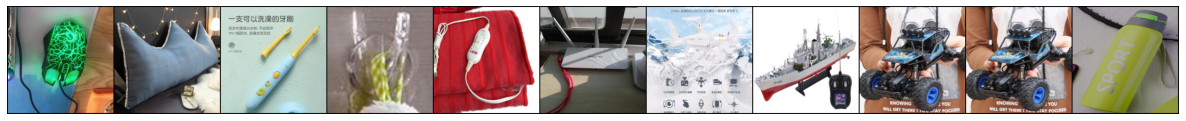

In [55]:
result = pd.read_csv('./submission.csv',header=None)

num = 189     # choose any integer between [0,41573]

query_img = Image.open(Config.query_dir+result.iloc[num,0])
query_img = Config.transformer(query_img).unsqueeze(0)

img_list = query_img
for img in result.iloc[num,1:]:
    image = Image.open(Config.gallery_dir+img)
    image = Config.transformer(image).unsqueeze(0)
    img_list = torch.cat([img_list,image])

imshow(torchvision.utils.make_grid(img_list, nrow=img_list.shape[0]))